In [1]:
!git clone https://github.com/tperl/liver_segmentation_project
!git clone https://github.com/MrGiovanni/UNetPlusPlus.git
!cd UNetPlusPlus
!cp /content/liver_segmentation_project/baseline/model.py /usr/local/lib/python3.6/dist-packages/

Cloning into 'liver_segmentation_project'...
remote: Enumerating objects: 3230, done.
remote: Total 3230 (delta 0), reused 0 (delta 0), pack-reused 3230
Receiving objects: 100% (3230/3230), 317.25 MiB | 30.04 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Checking out files: 100% (3189/3189), done.
Cloning into 'UNetPlusPlus'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 532 (delta 0), reused 1 (delta 0), pack-reused 529
Receiving objects: 100% (532/532), 5.81 MiB | 7.47 MiB/s, done.
Resolving deltas: 100% (265/265), done.


## Set pheripherials for tensorboard

In [2]:

# Set pheripherials for tensorboard
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


--2019-05-30 15:55:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.203.102.189, 34.232.40.183, 52.45.111.123, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.203.102.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16648024 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  15.88M  16.0MB/s    in 1.0s    

2019-05-30 15:55:46 (16.0 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [16648024/16648024]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
https://3f66f6d0.ngrok.io


## Set costume loss functions

In [0]:
def precision_loss(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  precision_loss = tf.metrics.precision(y_true_f,y_pred_f,weights=None)
  return precision_loss
  
def recall_loss(y_true, y_pred): 
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  recall_loss    = tf.metrics.recall(y_true_f,y_pred_f,weights=None)
  return recall_loss

def dice_coef(y_true, y_pred, smooth=1):
  """
  Dice = 2*TP/ (2TP + FP + FN)
       =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
  ref: https://arxiv.org/pdf/1606.04797v1.pdf
  """
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(K.abs(y_true_f * y_pred_f))
  dice_loss      = (2.1 * intersection + smooth) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + smooth)
  #Loss = tf.math.scalar_mul(alpha,dice_loss) + tf.math.scalar_mul(beta,precision_loss) + tf.math.scalar_mul(gama,recall_loss)
  Loss = dice_loss
  return Loss

def dice_coef_loss(y_true, y_pred):
  return 1-dice_coef(y_true, y_pred)

def combined_weighted_loss(y_true, y_pred):
  alpha = 0.6
  beta = 0.2
  gama = 0.2
  return alpha*dice_coef(y_true, y_pred)+beta*recall_loss(y_true, y_pred)+gama*precision_loss(y_true, y_pred)


## Configure model and run training on train and validation data

In [4]:
from UNetPlusPlus.segmentation_models import Unet
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.utils import to_categorical

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau

import numpy as np
'''
train_input_path = 'liver_segmentation_project/data/ct/train/'
val_input_path = 'liver_segmentation_project/data/seg/train/'
train_images = os.listdir(train_input_path)
val_images = os.listdir(val_input_path)

width = 256
'''
from model import *

train_input_path = 'liver_segmentation_project/data/ct/train/'
val_input_path = 'liver_segmentation_project/data/ct/val/'
#val_input_path = 'liver_segmentation_project/data/seg/train/'
train_images = os.listdir(train_input_path)
val_images = os.listdir(val_input_path)

width = 256

###### set tensorBoard callbacks ######
!mkdir logs
log_dir = "./logs"
tbCallBack = TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

# default 'resnet50'
model = Unet(backbone_name='inceptionv3',input_shape =(width,width,3), encoder_weights='imagenet', decoder_block_type='transpose',classes=3 ,activation = 'relu')
model.summary()
model.compile(loss=dice_coef_loss,
              optimizer='adam',
              metrics=[dice_coef])
#model.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])

print('preparing data...')
x_train = np.zeros((len(train_images),width,width,3))
y_train = np.zeros((len(train_images),width,width,3))

x_val = np.zeros((len(val_images),width,width,3))
y_val = np.zeros((len(val_images),width,width,3))

for ii, file in enumerate(train_images):
    img = cv2.imread(train_input_path+file, 0)
    img = cv2.resize(img,(width,width),cv2.INTER_NEAREST)
    if (ii<10):
        print(file)
    x_train[ii,:,:,0] = img
    x_train[ii,:,:,1] = img
    x_train[ii,:,:,2] = img

    seg_path = (train_input_path+file).replace('ct/train/ct','seg/train/seg')
    seg = cv2.imread(seg_path, 0)
    seg = cv2.resize(seg,(width,width),cv2.INTER_NEAREST)
    #y_train[ii,:,:,0] = (seg==0).astype(int)
    #y_train[ii,:,:,1] = (seg==127).astype(int)
    #y_train[ii,:,:,2] = (seg==255).astype(int)
    y_train[ii,:,:,0] = (seg==127).astype(int)
    y_train[ii,:,:,1] = (seg==255).astype(int)
    y_train[ii,:,:,2] = (seg==255).astype(int)


for ii, file in enumerate(val_images):
    img = cv2.imread(val_input_path+file, 0)
    img = cv2.resize(img,(width,width),cv2.INTER_NEAREST)
    x_val[ii,:,:,0] = img
    x_val[ii,:,:,1] = img
    x_val[ii,:,:,2] = img

    seg_path = (val_input_path+file).replace('ct/val/ct','seg/val/seg')
    seg = cv2.imread(seg_path, 0)
    seg = cv2.resize(seg, (width,width),cv2.INTER_NEAREST)
    #y_val[ii,:,:,0] = (seg==0).astype(int)
    #y_val[ii,:,:,1] = (seg==127).astype(int)
    #y_val[ii,:,:,2] = (seg==255).astype(int)
    y_val[ii,:,:,0] = (seg==127).astype(int)
    y_val[ii,:,:,1] = (seg==255).astype(int)
    y_val[ii,:,:,2] = (seg==255).astype(int)


#model.load_weights('baselin_00.h5')
model.optimizer.lr.assign(0.0001)
# preds = model.predict(x_val)
# seg_image = preds_to_image(preds)
model.fit(x_train, y_train, validation_data=(x_val, y_val),callbacks=[reduce_lr,tbCallBack], batch_size=4, epochs=10)
model.save_weights('baselin_try09.h5')
print('done')




Using TensorFlow backend.


mkdir: cannot create directory ‘logs’: File exists
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_

## Run model and visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

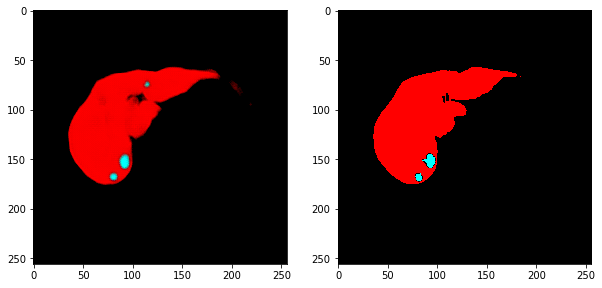

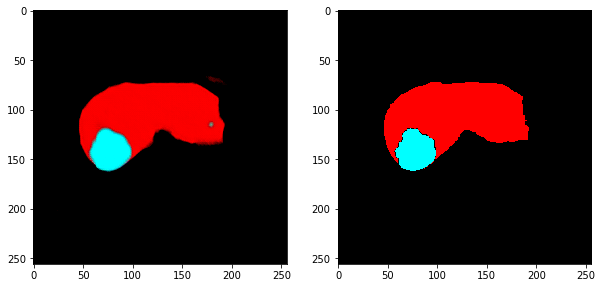

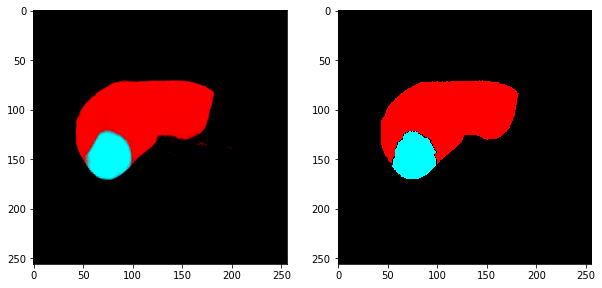

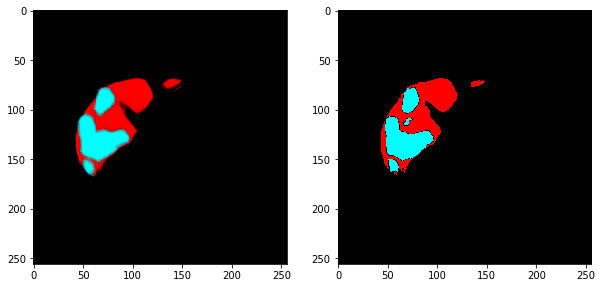

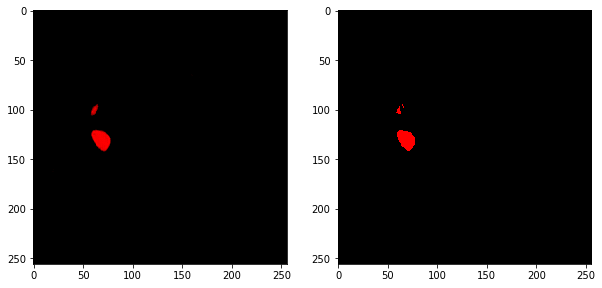

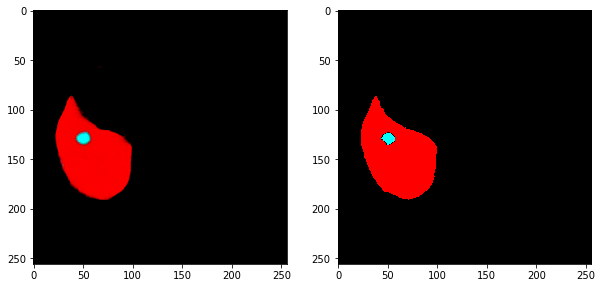

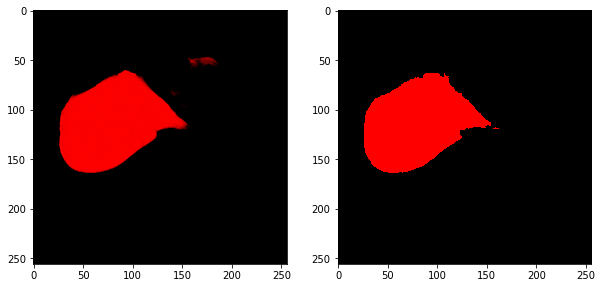

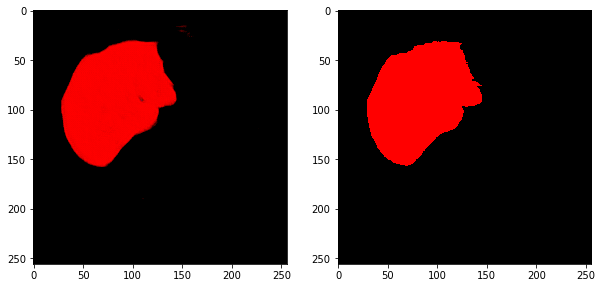

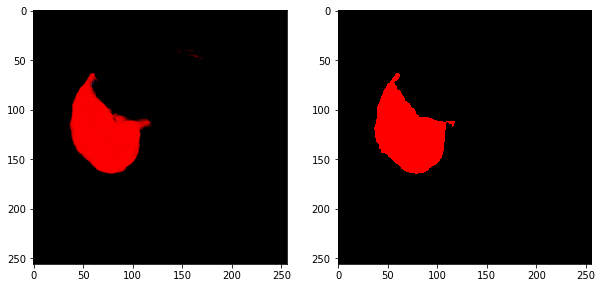

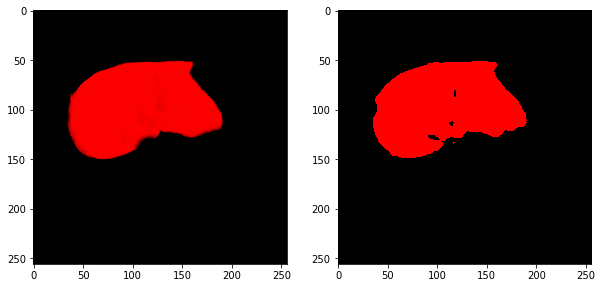

In [5]:
# Consts
num_batches = 1
batch_size  = 10
num_batch = 100

# Load trained model weights 
model.load_weights('/content/baselin_try08.h5')

# Loop over train images and compare prediction to train images and original images
# for num_batch in range(num_batches):
predictions = model.predict(x_train[batch_size*num_batch:(num_batch+1)*batch_size])
input_data  = y_train[batch_size*num_batch:(num_batch+1)*batch_size]
fignum = 0
for pred,origin in zip(predictions, input_data):
  plt.figure(num=fignum,figsize=(10,10))
  plt.subplot(1, 2, 1)
  plt.imshow(pred)
  plt.subplot(1, 2, 2)
  plt.imshow(origin)
  fignum+=1

      


## labeling pixels with treshold

In [0]:
def label_image_pixels(image):
  
  THRESHOLD = 0.1
  
  liver_location = np.where((image[:,:,1] >=THRESHOLD) & (image[:,:,0] >= THRESHOLD))
  lesion_location = np.where( (image[:,:,1] > image[:,:,2]) & (image[:,:,1] >= THRESHOLD))
  no_label = np.where((image[:,:,1] < THRESHOLD)&(image[:,:,2] < THRESHOLD))

  
  
  new_image = np.array(image)
  new_image = np.zeros((256,256))
  
  #plt.imshow(img[:,:,:])   
  #plt.show()

  new_image[lesion_location] = 255
  new_image[liver_location] = 127
  new_image[no_label] = 0
  
  
  return new_image

## Evaluation

In [0]:
def evaluation(predicted, ground_truth):
  predicted = np.around(seg_reshaped.ravel())
  ground_truth = np.around(seg_reshaped.ravel())

  precision, recall, dice, _ = score(ground_truth, predicted)

  #plt.title('classes distribution')
  #plt.hist(predicted, bins='auto')
  #plt.show()

  print('precision: {}'.format(precision))
  print('recall: {}'.format(recall))
  print('dice: {}'.format(dice))

## resize image

In [0]:
def resize_image(image):
  width = 512

  # segmentation
  seg = np.array(image)
  seg_reshaped = cv2.resize(seg,(width,width),interpolation = cv2.INTER_NEAREST)

  return seg_reshaped
  #print('original image size:', np.array(seg).shape)
  #plt.title("original")
  #plt.imshow(seg, cmap='gray')
  #plt.show()

  #print('reshaped image size:', np.array(seg_reshaped).shape)
  #plt.title("reshaped")
  #plt.imshow(seg_reshaped, cmap='gray')
  #plt.show()

## Run Two models to Background seg and liver and lesion seg -- For  FUSION Output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


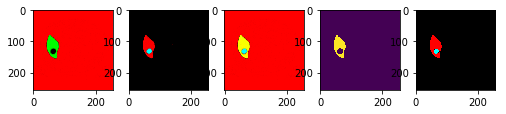

In [16]:
# Run fusion of models
# Consts
num_batches = 1
batch_size  = 1
num_batch = 1

# Load trained model weights 
model_back = Unet(backbone_name='inceptionv3',input_shape =(width,width,3), encoder_weights='imagenet', decoder_block_type='transpose',classes=3 ,activation = 'relu')
model_back.compile(loss=dice_coef_loss,optimizer='adam', metrics=[dice_coef])
model_back.load_weights('/content/baselin_try06.h5')

model_liverandlession = Unet(backbone_name='inceptionv3',input_shape =(width,width,3), encoder_weights='imagenet', decoder_block_type='transpose',classes=3 ,activation = 'relu')
model_liverandlession.compile(loss=dice_coef_loss,optimizer='adam', metrics=[dice_coef])
model_liverandlession.load_weights('/content/baselin_try08.h5')

# Loop over train images and compare prediction to train images and original images
# for num_batch in range(num_batches):
predictions_bg = model_back.predict(x_train[batch_size*num_batch:(num_batch+1)*batch_size])
predictions_lv = model_liverandlession.predict(x_train[batch_size*num_batch:(num_batch+1)*batch_size])
input_data  = y_train[batch_size*num_batch:(num_batch+1)*batch_size]
fignum = 0
for pred_bg,pred_lv,origin in zip(predictions_bg,predictions_lv, input_data):
  plt.figure(num=fignum,figsize=(10,10))
  plt.subplot(1, 6, 1)
  plt.imshow(pred_bg)
  plt.subplot(1, 6, 2)
  plt.imshow(pred_lv)
  plt.subplot(1, 6, 3)
  plt.imshow(pred_bg+pred_lv)
  plt.subplot(1, 6, 4)
  plt.imshow((label_image_pixels(pred_bg)))
  plt.subplot(1, 6, 5)
  plt.imshow(origin)
  fignum+=1
  
  

## post processing - Main

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1.0032026 0.        0.       ]
[  0. 127. 255.]


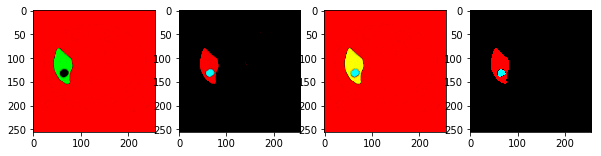

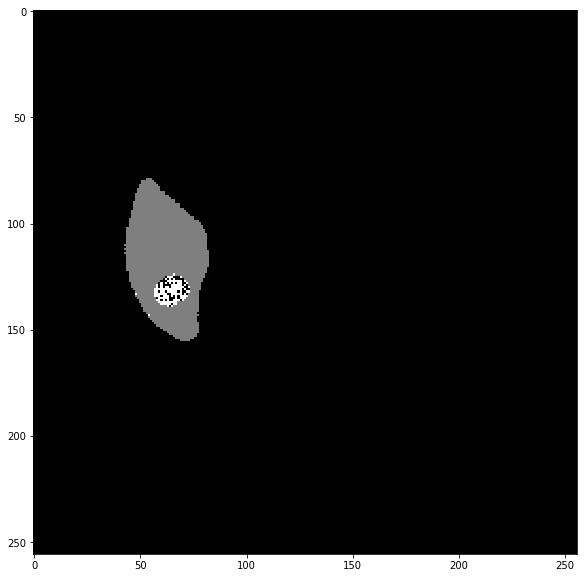

In [81]:
for pred_bg,pred_lv,origin in zip(predictions_bg,predictions_lv, input_data):
  plt.figure(num=fignum,figsize=(10,10))
  plt.subplot(1, 4, 1)
  plt.imshow(pred_bg)
  plt.subplot(1, 4, 2)
  plt.imshow(pred_lv)
  plt.subplot(1, 4, 3)
  plt.imshow(pred_bg+pred_lv)
  plt.subplot(1, 4, 4)
  plt.imshow(origin)
  fignum+=1

plt.figure(num=fignum,figsize=(10,10))
net_output = pred_bg+pred_lv
print(net_output[0,65])

labeled = label_image_pixels(net_output)
print(np.unique(labeled))
plt.imshow(labeled, cmap='gray')
plt.show()

## Not Used for now

In [0]:

import tensorflow.contrib.keras.api.keras.layers as KL
from tensorflow.keras.models import Model


def convLayer(input, kernel_size, num_of_filters, stride, padding, isSeperable, name):
    if isSeperable:
        layer = KL.SeparableConv2D(filters=num_of_filters, kernel_size=(kernel_size, kernel_size), padding=padding, strides=(stride, stride),
                          use_bias=False, name=name)(input)
    else:
        layer = KL.Conv2D(filters=num_of_filters, kernel_size=(kernel_size, kernel_size), padding=padding, strides=(stride, stride),
                          use_bias=False, name=name)(input)

    layer = KL.BatchNormalization(momentum=0.95, center=True, epsilon=0.001, scale=False)(layer)
    layer = KL.Activation(activation='relu')(layer)
    return layer

def deconvLayer(input, kernel_size, num_of_filters, stride, padding, name):
    layer = KL.Conv2DTranspose(filters=num_of_filters, kernel_size=(kernel_size, kernel_size), padding=padding, strides=(stride, stride),
                          use_bias=False, name=name)(input)
    layer = KL.BatchNormalization(momentum=0.95, center=True, epsilon=0.001, scale=False)(layer)
    layer = KL.Activation(activation='relu')(layer)
    return layer



def liverNet(input): # input 50,50
    #input 50,50
    seperable=False
    model = convLayer(input, 3, 8, 1, 'same', isSeperable=seperable) #128
    c1 = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)
    model = KL.MaxPooling2D(pool_size=(2, 2))(c1)
    model = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable) #64
    c2 = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)
    model = KL.MaxPooling2D(pool_size=(2, 2))(c2)
    model = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable) #32
    c3 = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)
    model = KL.MaxPooling2D(pool_size=(2, 2))(c3)
    model = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable) #16
    c4 = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)
    model = KL.MaxPooling2D(pool_size=(2, 2))(c4)
    model = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable) #8
    c5 = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)
    model = KL.MaxPooling2D(pool_size=(2, 2))(c5)
    model = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable) #4
    c6 = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)
    model = KL.MaxPooling2D(pool_size=(2, 2))(c6)
    model = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable) #2
    c7 = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)
    model = KL.MaxPooling2D(pool_size=(2, 2))(c7)
    feature_vector = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable) #1
    model = deconvLayer(feature_vector, 3, 8, 1, 'same', name='deconv1')  # 2
    model = KL.concatenate([model,c7], axis=3)
    model = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)  # 4
    model = deconvLayer(model, 3, 8, 1, 'same')
    model = KL.concatenate([model, c6], axis=3)
    model = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)  # 8
    model = deconvLayer(model, 3, 8, 1, 'same')
    model = KL.concatenate([model, c5], axis=3)
    model = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)  # 16
    model = deconvLayer(model, 3, 8, 1, 'same')
    model = KL.concatenate([model, c4], axis=3)
    model = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)  # 32
    model = deconvLayer(model, 3, 8, 1, 'same')
    model = KL.concatenate([model, c2], axis=3)
    model = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)  # 64
    model = deconvLayer(model, 3, 8, 1, 'same')
    model = KL.concatenate([model, c1], axis=3)
    model = convLayer(model, 3, 8, 1, 'same', isSeperable=seperable)  # 128
    model = deconvLayer(model, 3, 8, 1, 'same')
    return model

def FCN8(nClasses, input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height % 32 == 0
    assert input_width % 32 == 0
    IMAGE_ORDERING = "channels_last"

    img_input = KL.Input(shape=(input_height, input_width, 1))  ## Assume 224,224,3

    ## Block 1
    x = KL.Conv2D(8, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING)(
        img_input)
    x = KL.Conv2D(8, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = KL.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING)(x)
    f1 = x

    # Block 2
    x = KL.Conv2D(16, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = KL.Conv2D(16, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = KL.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING)(x)
    f2 = x

    # Block 3
    x = KL.Conv2D(32, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = KL.Conv2D(32, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = KL.Conv2D(64, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = KL.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING)(x)
    pool3 = x

    # Block 4
    x = KL.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = KL.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = KL.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    pool4 = KL.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING)(
        x)  ## (None, 14, 14, 512)

    # Block 5
    x = KL.Conv2D(256, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING)(pool4)
    x = KL.Conv2D(256, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = KL.Conv2D(256, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    pool5 = KL.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING)(
        x)  ## (None, 7, 7, 512)

    n = 1024
    o = (KL.Conv2D(n, (7, 7), activation='relu', padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = (KL.Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)

    ## 4 times upsamping for pool4 layer
    conv7_4 = KL.Conv2DTranspose(nClasses, kernel_size=(4, 4), strides=(4, 4), use_bias=False, data_format=IMAGE_ORDERING)(
        conv7)

    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = (
        KL.Conv2D(nClasses, (1, 1), activation='relu', padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (
        KL.Conv2DTranspose(nClasses, kernel_size=(2, 2), strides=(2, 2), use_bias=False, data_format=IMAGE_ORDERING))(pool411)

    pool311 = (
        KL.Conv2D(nClasses, (1, 1), activation='relu', padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)

    o = KL.Add(name="add")([pool411_2, pool311, conv7_4])
    o1 = KL.Conv2DTranspose(3, kernel_size=(8, 8), strides=(8, 8), use_bias=False, data_format=IMAGE_ORDERING)(o)
    o1 = (KL.Activation('softmax'))(o1)
    # o2 = KL.Conv2DTranspose(2, kernel_size=(8, 8), strides=(8, 8), use_bias=False, data_format=IMAGE_ORDERING)(o)
    # o2 = (KL.Activation('softmax'))(o2)
    # o3 = KL.Conv2DTranspose(2, kernel_size=(8, 8), strides=(8, 8), use_bias=False, data_format=IMAGE_ORDERING)(o)
    # o3 = (KL.Activation('softmax'))(o3)

    model = Model(img_input, o1)

    return model





In [0]:
from UNetPlusPlus.segmentation_models import Unet
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.utils import to_categorical

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.callbacks import TensorBoard
import numpy as np

from model import *

train_input_path = 'liver_segmentation_project/data/ct/train/'
val_input_path = 'liver_segmentation_project/data/ct/val/'
#val_input_path = 'liver_segmentation_project/data/seg/train/'
train_images = os.listdir(train_input_path)
val_images = os.listdir(val_input_path)

width = 256

###### set tensorBoard callbacks ######
!mkdir logs
log_dir = "./logs"
tbCallBack = TensorBoard(log_dir=log_dir, histogram_freq=1, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')


###### set model and compile     ######
model = Unet(backbone_name='resnet50',input_shape =(256,256,3), encoder_weights='imagenet', decoder_block_type='transpose',classes=3 ,activation = 'relu')
#model = FCN8(3, input_height=width, input_width=width)
model.summary()
#model.compile(loss='binary_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])

#model.compile(loss=dice_coef_loss,
#              optimizer='adam',
#              metrics=[dice_coef])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('preparing data...')
x_train = np.zeros((len(train_images),width,width,3))
#x_train = np.zeros((len(train_images),width,width,1))
y_train = np.zeros((len(train_images),width,width,3))

x_val = np.zeros((len(val_images),width,width,3))
#x_val = np.zeros((len(val_images),width,width,1))
y_val = np.zeros((len(val_images),width,width,3))

for ii, file in enumerate(train_images):
    img = cv2.imread(train_input_path+file, 0)
    img = cv2.resize(img,(width,width),cv2.INTER_NEAREST)
    x_train[ii,:,:,0] = img
    x_train[ii,:,:,1] = img
    x_train[ii,:,:,2] = img

    seg_path = (train_input_path+file).replace('ct/train/ct','seg/train/seg')
    seg = cv2.imread(seg_path, 0)
    seg = cv2.resize(seg,(width,width),cv2.INTER_NEAREST)
    y_train[ii,:,:,0] = (seg==0).astype(int)
    y_train[ii,:,:,1] = (seg==127).astype(int)
    y_train[ii,:,:,2] = (seg==255).astype(int)

for ii, file in enumerate(val_images):
    img = cv2.imread(val_input_path+file, 0)
    img = cv2.resize(img,(width,width),cv2.INTER_NEAREST)
    x_val[ii,:,:,0] = img
    x_val[ii,:,:,1] = img
    x_val[ii,:,:,2] = img

    seg_path = (val_input_path+file).replace('ct/val/ct','seg/val/seg')
    seg = cv2.imread(seg_path, 0)
    seg = cv2.resize(seg, (width,width),cv2.INTER_NEAREST)
    y_val[ii,:,:,0] = (seg==0).astype(int)
    y_val[ii,:,:,1] = (seg==127).astype(int)
    y_val[ii,:,:,2] = (seg==255).astype(int)

def preds_to_image(preds):
    new_image = np.zeros((width, width))

    bg_location = np.where(preds[0][0,:,:,1] > 0.4)
    liver_location = np.where(preds[1][0,:,:,1] > 0.4)
    lesion_location = np.where(preds[2][0, :, :, 1] > 0.4)
    new_image[liver_location] = 127
    new_image[lesion_location] = 255
    new_image[bg_location] = 0
    return new_image

#model.load_weights('baselin_00.h5')
model.optimizer.lr.assign(0.0001)
# preds = model.predict(x_val)
# seg_image = preds_to_image(preds)
model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[tbCallBack] ,batch_size=4, epochs=10)
model.save_weights('baselin_00_try_4.h5')
print('done')




In [0]:
def preds_to_image(preds):
    new_image = np.zeros((width, width))

    bg_location = np.where(preds[:,:,0] > 0.5)
    liver_location = np.where(preds[:,:,1] > 0.5)
    lesion_location = np.where(preds[ :, :, 2] > 0.5)
    print(lesion_location)
    new_image[liver_location] = 127
    new_image[lesion_location] = 255
    new_image[bg_location] = 0
    return new_image

In [0]:
model.load_weights('/content/baselin_try08.h5')
t = model.predict(x_train[0:10])
v = model.predict(x_val[0:10])

In [0]:
#!mkdir /content/imgs
grayscale_img = 0.2989 * t[0][:,:,0] + 0.5870 * t[0][:,:,1] + 0.1140 * t[0][:,:,2]
#new_img = preds_to_image(t[1])
#plt.imshow(new_img, cmap='gray', vmin=0, vmax=255)
#plt.imshow(new_img,'gray')
#plt.imshow(t[5,:,:,2],'gray')
#plt.imsave('/imgs/train_9.png',t[9])
plt.imshow(t[8])
plt.show()

In [0]:
for ii, file in enumerate(val_images):
    img = cv2.imread(val_input_path+file, 0)
    img = cv2.resize(img,(width,width),cv2.INTER_NEAREST)
    x_val[ii,:,:,0] = img
    seg_path = (val_input_path+file).replace('liver_segmentation_project/data/ct/val/ct','liver_segmentation_project/data/seg/val/seg')
    seg = cv2.imread(seg_path, 0)
    seg = cv2.resize(seg,(width,width),cv2.INTER_NEAREST)
    y_val[ii,:,:,0] = (seg==0).astype(int)
    y_val[ii,:,:,1] = (seg==127).astype(int)
    y_val[ii,:,:,2] = (seg==255).astype(int)